In [11]:
import time
import os
import seaborn as sns
import numpy as np
import pandas as pd
import sys
%load_ext autoreload
%autoreload 2
from mimas.tools.spectral_file.extract_ms1_feature import process_mzml_file, extract_ms2_spectra, find_features
import logging
from toolsets.spectra_operations import entropy_similarity_default
from toolsets.std_list_prep import complete_adducts, complete_formula
# from toolsets.API_gets import complete_smiles
from toolsets.search import string_search, num_search
import toolsets.spectra_operations as so
from tqdm import tqdm
from toolsets.features_by_alphapept import find_features_alphapept
import matplotlib.pyplot as plt
import seaborn as sns
EAD_source = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD'
UVPD_source = "/Users/fanzhoukong/Documents/GitHub/Libgen_data/UVPD"
figure_source = "/Users/fanzhoukong/Documents/GitHub/Libgen_data/manuscript"
ead_source_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD'
uvpd_source_dir = "/Users/fanzhoukong/Documents/GitHub/Libgen_data/UVPD"
uvpd_lib = pd.read_csv(os.path.join(uvpd_source_dir, 'UVPD_library_cla.csv'))
hcd_lib = pd.read_csv(os.path.join(uvpd_source_dir, 'HCD_library_cla.csv'))
ead_lib = pd.read_csv(os.path.join(ead_source_dir, 'EAD_library_cla.csv'))
# ead_pfp_lib =pd.read_csv(os.path.join(ead_source_dir, 'data_pfp_lib_final.csv'))
# ead_hilic_lib =pd.read_csv(os.path.join(ead_source_dir, 'data_hilic_lib_final.csv'))
# ead_lib = pd.concat([ead_pfp_lib, ead_hilic_lib], axis=0, ignore_index=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def find_non_ord_adduct(lib, adducts):


    count = 0
    for inchi in lib['reference_inchikey'].unique():
        lib_temp = string_search(lib, 'reference_inchikey', inchi)
        original_lenght = len(lib_temp)
        for adduct in adducts:
            lib_temp = string_search(lib_temp, 'reference_adduct', adduct, reverse=True)

        if len(lib_temp)==original_lenght:
            count = count+1
        # if len(lib_temp)>0:
        #     count = count+1
    return (count)
def classifier_cleanup(data):
    data_pie = string_search(data, 'class','smiles_not_found', reverse=True)
    data_pie = string_search(data_pie, 'class','classyfire_error_smiles', reverse=True)
    return(data_pie)

# start of polygenic tree

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
def tanimoto_similarity(smi1, smi2):
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits=2048)
    s = round(DataStructs.TanimotoSimilarity(fp1,fp2),3)
    return s
def create_proxi_matrix(data, lib_name, smile_column = 'reference_smiles'):
    data = classifier_cleanup(data)
    smile_list = list(data[smile_column].unique())
    i = 0
    proxi_matrix = pd.DataFrame()
    for smile in tqdm(smile_list):
        distance_temp = []
        for smile_inner in smile_list:
            distance_temp.append(1-tanimoto_similarity(smile, smile_inner))
        # return(distance_temp)
        df_temp = pd.DataFrame(distance_temp, index =smile_list,
                                              columns =[smile])
        # return(df_temp)
        proxi_matrix = pd.concat([proxi_matrix, df_temp], axis=1, ignore_index=True)
    proxi_matrix.columns = smile_list
    proxi_matrix['Library_id'] =  (np.arange(len(proxi_matrix)))
    proxi_matrix['Library_id'] = lib_name + proxi_matrix['Library_id'].astype(str)
    classes = []
    kingdom = []
    superclass = []
    for index, row in proxi_matrix.iterrows():
        data_temp = string_search(data, 'reference_smiles', index)
        classes.append(data_temp.iloc[0]['class'])
        kingdom.append(data_temp.iloc[0]['kingdom'])
        superclass.append(data_temp.iloc[0]['superclass'])
    proxi_matrix['class']=classes
    proxi_matrix['superclass']=superclass
    proxi_matrix['kingdom']=kingdom
    return (proxi_matrix)


In [20]:
proxi_matrix_ead = create_proxi_matrix(hcd_lib, lib_name='HCD')

100%|██████████| 1256/1256 [05:04<00:00,  4.12it/s]


In [21]:
proxi_matrix_ead.head()

,OCC1(O)COC(OCC2OC(OC(CCCCc3ccc(O)cc3)CCc3ccc(O)cc3)C(OC3OCC(O)(CO)C3O)C(O)C2O)C1O,COC(C(=O)C(O)C(C)O)C1Cc2cc3cc(OC4CC(OC5CC(O)C(OC)C(C)O5)C(OC(C)=O)C(C)O4)c(C)c(O)c3c(O)c2C(=O)C1OC1CC(OC2CC(OC3CC(C)(O)C(OC(C)=O)C(C)O3)C(O)C(C)O2)C(O)C(C)O1,COc1cc(CCCOC(=O)CCc2ccc(O)cc2)ccc1O,C=C1CCC2C(C)(CO)C(OC3OC(CO)C(O)C(O)C3O)CCC2(C)C1CC=C1C(=O)OCC1O,CCCCCC1C(=O)OC(C)C(NC(=O)c2cccc(NC=O)c2O)C(=O)OC(C)C1OC(=O)CC(C)C,CCCCCc1cc(O)c(CC=C(C)C)c(O)c1CC=C(C)C,O=C(OCc1cccc(O)c1OC1OC(CO)C(O)C(O)C1O)C1(O)C(=O)C2C=CC1C1C=CC(=O)C(O)(C(=O)OCc3cccc(O)c3OC3OC(CO)C(O)C(O)C3O)C21,C=C(CCCCCCCC(=O)O)C(=O)OC,CC(=CCCC(CO)C1CCC2(C)C3CCC4C(C)(C)C(OC5OC(CO)C(O)C(O)C5O)CC(O)C45CC35CCC12C)COC1OC(CO)C(O)C(O)C1O,COc1cc(C(=O)C(C)=C(C)C(=O)c2ccc(O)c(OC)c2)ccc1O,...,COc1cc(OC)c2c(=O)c(OC)c(-c3ccc(OC)c(OC)c3)oc2c1,CC(C)c1ccc2c(c1)CCC1C(C)(C(N)=O)CCCC21C,COc1cc2occc2c2oc(=O)ccc12,COc1ccc(C2CC(=O)c3c(O)cc(O)cc3O2)cc1O,CC(=O)Nc1ccccc1O,CC1(C=O)CCCC2(C)C1CCC13CC(CO)C(CCC12)C3,Library_id,class,superclass,kingdom
OCC1(O)COC(OCC2OC(OC(CCCCc3ccc(O)cc3)CCc3ccc(O)cc3)C(OC3OCC(O)(CO)C3O)C(O)C2O)C1O,0.000,0.884,0.824,0.865,0.915,0.911,0.870,0.948,0.874,0.941,...,0.949,0.935,0.921,0.902,0.946,0.927,HCD0,Diarylheptanoids,Phenylpropanoids and polyketides,Organic compounds
COC(C(=O)C(O)C(C)O)C1Cc2cc3cc(OC4CC(OC5CC(O)C(OC)C(C)O5)C(OC(C)=O)C(C)O4)c(C)c(O)c3c(O)c2C(=O)C1OC1CC(OC2CC(OC3CC(C)(O)C(OC(C)=O)C(C)O3)C(O)C(C)O2)C(O)C(C)O1,0.884,0.000,0.918,0.914,0.883,0.937,0.912,0.952,0.903,0.927,...,0.935,0.907,0.938,0.899,0.937,0.947,HCD1,Organooxygen compounds,Organic oxygen compounds,Organic compounds
COc1cc(CCCOC(=O)CCc2ccc(O)cc2)ccc1O,0.824,0.918,0.000,0.933,0.910,0.879,0.905,0.873,0.955,0.740,...,0.891,0.905,0.880,0.835,0.882,0.954,HCD2,Phenols,Benzenoids,Organic compounds
C=C1CCC2C(C)(CO)C(OC3OC(CO)C(O)C(O)C3O)CCC2(C)C1CC=C1C(=O)OCC1O,0.865,0.914,0.933,0.000,0.920,0.935,0.830,0.937,0.763,0.948,...,0.940,0.892,0.935,0.924,0.944,0.856,HCD3,Organooxygen compounds,Organic oxygen compounds,Organic compounds
CCCCCC1C(=O)OC(C)C(NC(=O)c2cccc(NC=O)c2O)C(=O)OC(C)C1OC(=O)CC(C)C,0.915,0.883,0.910,0.920,0.000,0.883,0.904,0.929,0.941,0.922,...,0.917,0.919,0.920,0.902,0.886,0.950,HCD4,Benzene and substituted derivatives,Benzenoids,Organic compounds


In [22]:
proxi_matrix_ead.to_csv(os.path.join(ead_source_dir, 'proxi_matrix_HCD.csv'), index=True)

# end of polygenic tree

In [15]:
smile_list = list(ead_lib['reference_smiles'].unique())

In [17]:

for smile in smile_list:
    distance_temp = []
    for smile_inner in smile_list:
        distance_temp.append(tanimoto_similarity(smile, smile_inner))
    break

In [19]:
len(distance_temp)

1783

In [20]:
len(smile_list)

1783

In [2]:
from toolsets.file_io import export_library_msp

In [16]:
find_non_ord_adduct(ead_lib, ['[M+H]+'])

382

In [17]:
find_non_ord_adduct(ead_lib, ['[M+H]+'])/len(ead_lib['reference_inchikey'].unique())

0.21070049641478214

In [14]:
find_non_ord_adduct(hcd_lib, ['[M+H]+','[M-H]-'])/len(hcd_lib['reference_inchikey'].unique())

0.2243639167309175

In [15]:
find_non_ord_adduct(uvpd_lib, ['[M+H]+','[M-H]-'])/len(uvpd_lib['reference_inchikey'].unique())

0.3383270911360799

In [7]:
string_search(hcd_lib, 'reference_inchikey','XUWSHXDEJOOIND-MEVVXUJLSA-N')

,scan_number,precursor_mz,charge,ms1_intensity_ratio,ms1_precursor_intensity,retention_time,peaks,ms1_index,query_idx,reference_name,...,retention_time_wa,peaks_denoised,ei,c_id,peaks_denoised_normalized,normalized_entropy,normalized_entropy_raw,kingdom,superclass,class
101,215,363.1303,-1,0.992836,71184046,1.682225,59.013042\t0.11133922\n71.013069\t0.06486413\n...,65,148,"7-methyl-1-[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-...",...,1.682225,59.012496\t0.11133922\n71.012523\t0.06486413\n...,100.0,122,59.012496\t0.11133922\n71.012523\t0.06486413\n...,0.761010,0.761010,Organic compounds,Lipids and lipid-like molecules,Prenol lipids
102,217,423.1515,-1,0.974026,11337484,1.684883,59.013149\t0.06055694\n71.013069\t0.04126296\n...,65,150,"7-methyl-1-[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-...",...,1.684883,59.012603\t0.06055694\n71.012523\t0.04126296\n...,100.0,123,59.012603\t0.06055694\n71.012523\t0.04126296\n...,0.578815,0.578815,Organic compounds,Lipids and lipid-like molecules,Prenol lipids


In [4]:
export_library_msp(hcd_lib, typeofmsms='peaks_denoised_normalized', output_location=os.path.join(uvpd_source_dir, 'hcd_lib.txt'))

100%|██████████| 1947/1947 [00:00<00:00, 3478.39it/s]


# tree graphs

In [35]:
uvpd_pie = classifier_cleanup(uvpd_lib)

In [51]:
from toolsets.helpers import save_value_counts

In [52]:
uvpd_count =save_value_counts(uvpd_pie, 'superclass')

In [53]:
uvpd_count

,unique_values,counts
0,Lipids and lipid-like molecules,328
1,Phenylpropanoids and polyketides,233
2,Organoheterocyclic compounds,156
3,Organic oxygen compounds,98
4,Benzenoids,58
5,Organic acids and derivatives,46
6,"Lignans, neolignans and related compounds",28
7,Alkaloids and derivatives,17
8,"Nucleosides, nucleotides, and analogues",10
9,Homogeneous non-metal compounds,5


In [36]:
uvpd_pie['class'].value_counts()

Prenol lipids                    242
Organooxygen compounds            98
Coumarins and derivatives         77
Fatty Acyls                       44
Flavonoids                        43
                                ... 
Isocoumarans                       1
Saturated hydrocarbons             1
Eburnan-type alkaloids             1
Cinnamaldehydes                    1
Indolonaphthyridine alkaloids      1
Name: class, Length: 97, dtype: int64

In [45]:
df = uvpd_pie.groupby(["superclass", "class"]).size()

In [38]:
outer = df.groupby('superclass').sum()
inner = df.groupby(['superclass', 'class']).sum()
inner_labels = inner.index.get_level_values(1)

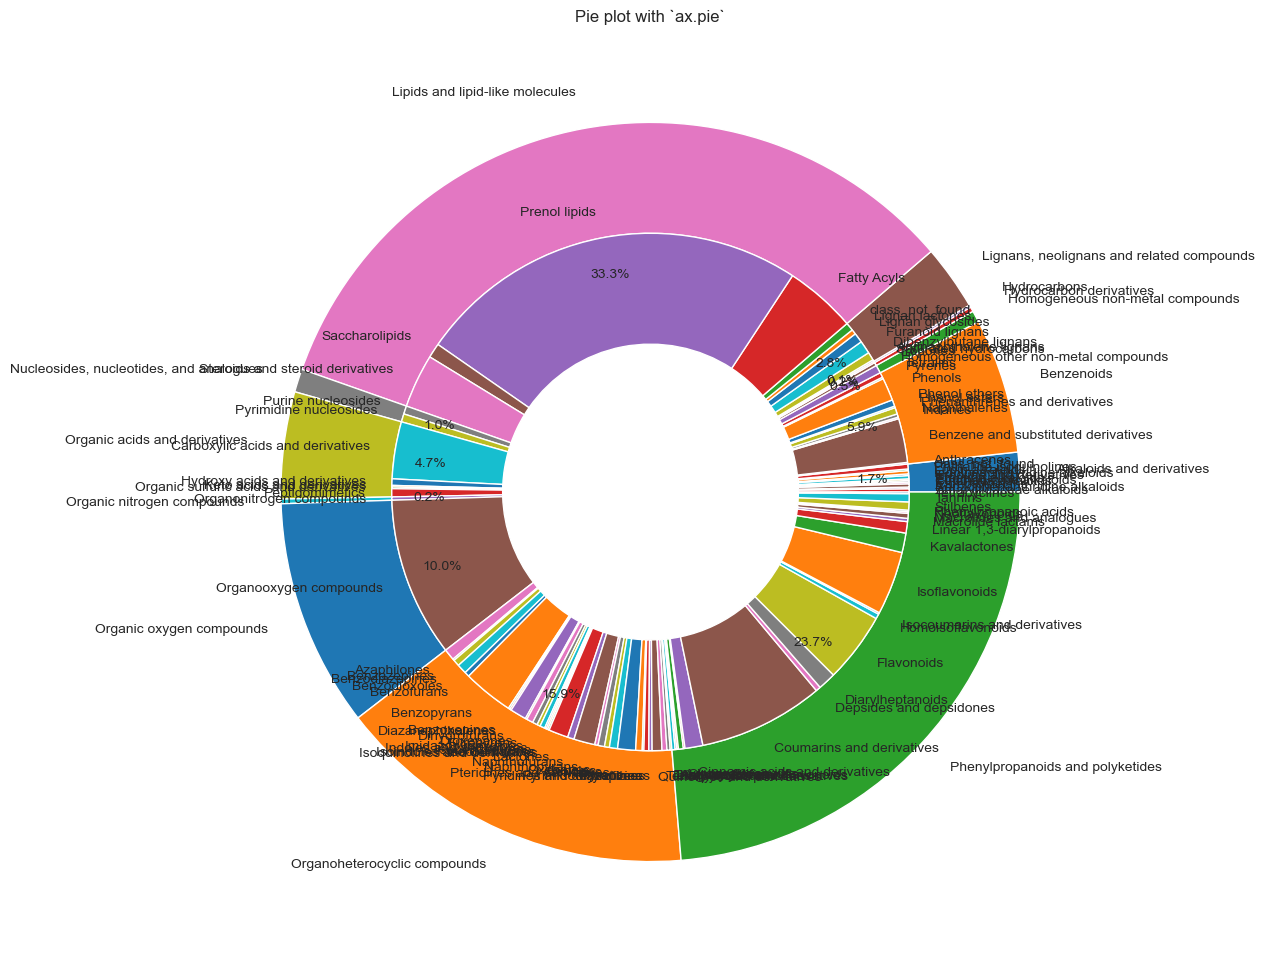

In [39]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(24,12))
size = 0.3

ax.pie(outer.values.flatten(), radius=1,
       labels=outer.index,
       autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(inner.values.flatten(), radius=1-size,
       labels = inner_labels,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

In [81]:
data_both_mode = pd.DataFrame()
for inchi in uvpd_lib['reference_inchikey'].unique():
    data_temp = string_search(uvpd_lib, 'reference_inchikey', inchi)
    if len(data_temp)>1 and '[M+H]+' in (data_temp['reference_adduct'].unique()) and '[M-H]-' in (data_temp['reference_adduct'].unique()):
        data_both_mode=pd.concat([data_both_mode, data_temp[data_temp['reference_adduct'].isin(['[M-H]-','[M+H]+'])]], axis = 0)
        # break

In [82]:
len(data_both_mode['reference_inchikey'].unique())

23

In [77]:
from toolsets.spectra_plotter import head_to_tail_plot

In [83]:
data_both_mode.sort_values(by=['reference_inchikey', 'reference_adduct'], inplace=True, ignore_index=True)

In [84]:
entropy_similarity_modes = []
for inchi in data_both_mode['reference_inchikey'].unique():
    data_temp = string_search(data_both_mode, 'reference_inchikey', inchi)
    entropy_similarity_modes.append(entropy_similarity_default(data_temp.iloc[0]['peaks_denoised_normalized'], data_temp.iloc[1]['peaks_denoised_normalized']))

In [99]:
data_both_mode.iloc[1]['peaks_denoised_normalized']

'44.084721\t0.00023056\n92.025879\t0.00943791\n104.025371\t0.05451931\n120.020243\t0.0579326\n148.015169\t0.01139365\n176.009956\t0.74978774\n177.017755\t0.11669823'

In [39]:
from toolsets.spectra_plotter import head_to_tail_plot

# UVPD both modes sample compound 1

In [92]:
data_temp = string_search(data_both_mode, 'reference_inchikey', data_both_mode['reference_inchikey'].unique()[0])

In [94]:
print(so.spectral_entropy(data_temp.iloc[0]['peaks_denoised_normalized']))
print(so.spectral_entropy(data_temp.iloc[1]['peaks_denoised_normalized']))

2.1515746
0.88715005


In [93]:
data_temp

,scan_number,precursor_mz,charge,ms1_intensity_ratio,ms1_precursor_intensity,retention_time,peaks,ms1_index,query_idx,reference_name,...,peaks_denoised,ei,c_id,peaks_denoised_normalized,normalized_entropy,normalized_entropy_raw,kingdom,superclass,class,entropy_similarity_uvpd
0,531,247.0953,1,0.980210,9782618,4.078590,77.037972\t0.212272\n79.053795\t0.012259\n81.0...,148,382,Prenyletin,...,77.03732\t0.212272\n79.053155\t0.012259\n81.03...,100.0000,4021,77.03732\t0.212272\n79.053155\t0.012259\n81.03...,0.332589,0.332589,Organic compounds,Phenylpropanoids and polyketides,Coumarins and derivatives,0.369557
1,502,245.0821,-1,0.998991,817093829,4.059557,92.026123\t0.00944031\n104.02562\t0.05453179\n...,149,351,Prenyletin,...,44.084721\t0.00023\n92.025879\t0.00941501\n104...,99.7574,5330,44.084721\t0.00023056\n92.025879\t0.00943791\n...,0.043201,0.013924,Organic compounds,Phenylpropanoids and polyketides,Coumarins and derivatives,0.755652


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

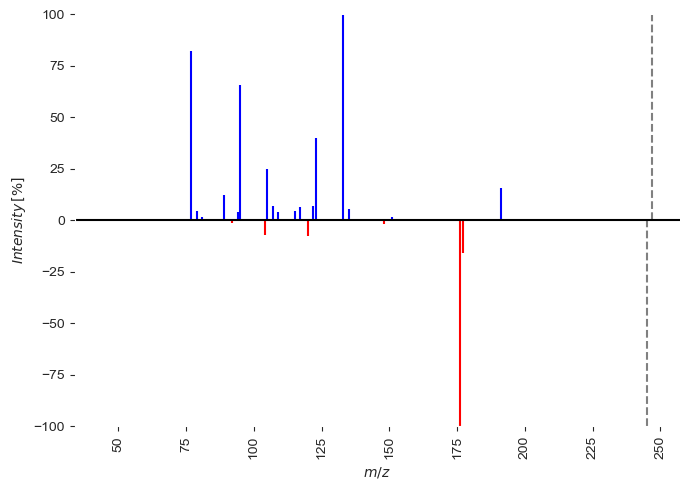

In [86]:
data_temp = string_search(data_both_mode, 'reference_inchikey', data_both_mode['reference_inchikey'].unique()[0])
head_to_tail_plot(data_temp.iloc[0]['peaks_denoised_normalized'],data_temp.iloc[1]['peaks_denoised_normalized'],  pmz1=data_temp.iloc[0]['precursor_mz'], pmz2=data_temp.iloc[1]['precursor_mz'],savepath=os.path.join(figure_source, data_temp.iloc[0]['reference_name']+'uvpd_both_modes.tiff'))

In [88]:
mol = Chem.MolFromSmiles(data_temp.iloc[0]['reference_smiles'])
Draw.MolToFile(mol,os.path.join(figure_source, data_temp.iloc[0]['reference_name']+data_temp.iloc[0]['reference_adduct']+'mol_fig.png'))

# UVPD sample compound 2

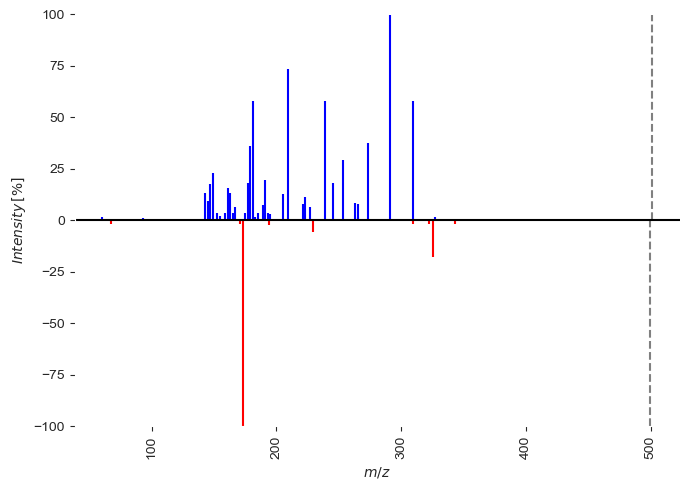

In [107]:
data_temp = string_search(data_both_mode, 'reference_inchikey', data_both_mode['reference_inchikey'].unique()[7])
head_to_tail_plot(data_temp.iloc[0]['peaks_denoised_normalized'],data_temp.iloc[1]['peaks_denoised_normalized'],  pmz1=data_temp.iloc[0]['precursor_mz'], pmz2=data_temp.iloc[1]['precursor_mz'],savepath=os.path.join(figure_source, data_temp.iloc[0]['reference_name']+'uvpd_both_modes.tiff'))
mol = Chem.MolFromSmiles(data_temp.iloc[0]['reference_smiles'])
Draw.MolToFile(mol,os.path.join(figure_source, data_temp.iloc[0]['reference_name']+data_temp.iloc[0]['reference_adduct']+'mol_fig.png'))

In [108]:
print(so.spectral_entropy(data_temp.iloc[0]['peaks_denoised_normalized']))
print(so.spectral_entropy(data_temp.iloc[1]['peaks_denoised_normalized']))

3.0849078
0.96816933


In [87]:
figure_source

'/Users/fanzhoukong/Documents/GitHub/Libgen_data/manuscript'

In [ ]:
for inchi in data_both_mode['reference_inchikey'].unique():
    data_temp = string_search(data_both_mode, 'reference_inchikey', inchi)
    head_to_tail_plot(data_temp.iloc[0]['peaks_denoised_normalized'],data_temp.iloc[1]['peaks_denoised_normalized'], savepath=os.path.join(figure_source, data_temp.iloc[0]['reference_name']+'.tiff'))

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

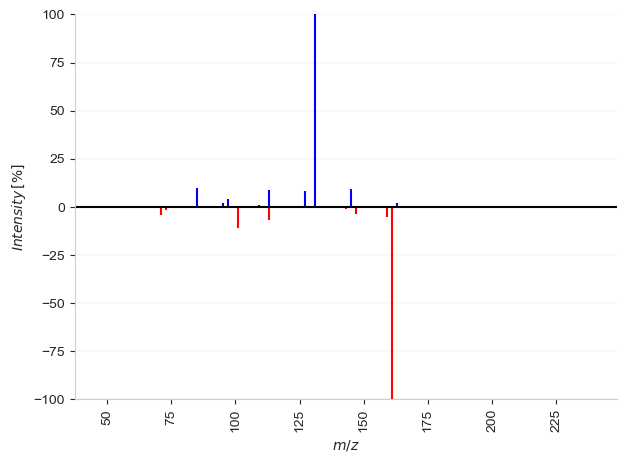

In [110]:
head_to_tail_plot(data_temp.iloc[0]['peaks_denoised_normalized'],data_temp.iloc[1]['peaks_denoised_normalized'], savepath=os.path.join(figure_source, data_temp.iloc[0]['reference_name']+'.tiff'))

In [ ]:
df2=df[df['Courses'].isin(['Spark'])]

In [45]:
# ead_lib.sort_values(by=['key','ms1_precursor_intensity'], inplace=True, ascending=False, ignore_index=True)
# wa_spectra = []
# for key in ead_lib['key'].unique():
#     data_temp = string_search(ead_lib, 'key', key)
#     if len(data_temp)==1:
#         # pass
#         wa_spectra.append(data_temp.iloc[0]['peaks_denoised_normalized'])
#     else:
#         # break
#         wa_spectra.append(so.weighted_average_spectra(data_temp,typeofmsms = 'peaks_denoised_normalized'))
# ead_lib= ead_lib.drop_duplicates(subset='key', keep='first')
# ead_lib['peaks_denoised_normalized']=wa_spectra
# from toolsets.denoising_related_functions import post_processing
# ead_lib_processed = post_processing(ead_lib, ei_threshold=90, denoised_column='peaks_denoised_normalized')
# ead_lib_processed.to_csv(os.path.join(ead_source_dir, 'EAD_library.csv'), index = False)

In [121]:
uvpd_lib

,scan_number,precursor_mz,charge,ms1_intensity_ratio,ms1_precursor_intensity,retention_time,peaks,ms1_index,query_idx,reference_name,...,retention_time_wa,peaks_denoised,ei,peaks_denoised_normalized,normalized_entropy,HCD_similarity,kingdom,superclass,class,entropy_similarity_uvpd
0,415,744.3413,1,0.988022,6.826756e+08,3.292875,115.03867\t0.00969363\n229.0701\t0.05804054\n2...,123,291,"(2R,3S,4S,5R,6R)-6-[1,7-bis(4-hydroxyphenyl)he...",...,3.292875,115.038907\t0.00969398\n229.070786\t0.05804088...,100.00000,115.038907\t0.00969398\n229.070786\t0.05804088...,0.325822,0.304002,Organic compounds,Phenylpropanoids and polyketides,Diarylheptanoids,0.304002
1,394,147.0435,1,0.917311,6.875321e+06,3.117204,51.022697\t0.00639815\n65.038094\t0.14331263\n...,117,276,COUMARIN,...,3.131351,51.023204\t0.004913\n55.054437\t0.00720901\n65...,94.67270,51.023204\t0.00518946\n55.054437\t0.00761467\n...,0.358328,0.681188,Organic compounds,Phenylpropanoids and polyketides,Coumarins and derivatives,0.681188
2,573,331.1528,1,0.981685,2.148011e+07,4.514689,91.053993\t0.00762302\n101.037949\t0.05699417\...,166,405,3-(4-hydroxy-3-methoxyphenyl)propyl 3-(4-hydro...,...,4.514689,91.054506\t0.00762302\n101.038491\t0.05699411\...,100.00000,91.054506\t0.00762302\n101.038491\t0.05699411\...,0.468090,0.076966,Organic compounds,Benzenoids,Phenols,0.076966
3,868,317.2463,1,0.967152,6.832537e+06,6.648360,91.053574\t0.04007071\n93.069466\t0.01261869\n...,243,623,"2,4-bis(3-methylbut-2-enyl)-5-pentylbenzene-1,...",...,6.648360,91.05379\t0.040071\n93.069691\t0.012619\n95.06...,100.00000,91.05379\t0.040071\n93.069691\t0.012619\n95.06...,0.449873,0.647409,Organic compounds,Benzenoids,Phenols,0.647409
4,287,497.1615,1,0.969295,1.619016e+07,2.199017,157.04665\t0.02039483\n169.04643\t0.03880064\n...,84,201,"1-[3-methoxy-4-[(2S,3R,4S,5S,6R)-3,4,5-trihydr...",...,2.199017,157.046622\t0.02039502\n169.046465\t0.03880104...,100.00000,157.046622\t0.02039502\n169.046465\t0.03880104...,0.467753,NaN,Organic compounds,Organic oxygen compounds,Organooxygen compounds,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,502,245.0821,-1,0.998991,8.170938e+08,4.059557,92.026123\t0.00944031\n104.02562\t0.05453179\n...,149,351,Prenyletin,...,4.059154,44.084721\t0.00023\n92.025879\t0.00941501\n104...,99.75740,44.084721\t0.00023056\n92.025879\t0.00943791\n...,0.043201,0.796028,Organic compounds,Phenylpropanoids and polyketides,Coumarins and derivatives,0.796028
999,442,507.2451,-1,0.995669,2.679859e+07,3.536408,71.013206\t0.04806533\n89.023308\t0.14679844\n...,131,309,"(2R,3S,4S,5R,6R)-2-[[(2R,3R,4R,5S)-3,4-dihydro...",...,3.536408,71.01259\t0.04806505\n89.022694\t0.14679815\n1...,93.88299,71.01259\t0.05119676\n89.022694\t0.15636288\n1...,0.702317,0.609554,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,0.609554
1000,443,569.2964,-1,0.997448,3.914438e+07,3.555684,179.05534\t0.05142983\n187.73123\t0.05406535\n...,130,312,"3-[(Z)-5-[6-hydroxy-5,5,8a-trimethyl-2-methyli...",...,3.555684,179.054826\t0.05143\n465.283206\t0.198788\n483...,94.59350,179.054826\t0.05436949\n465.283206\t0.21014975...,0.380144,NaN,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,NaN
1001,734,347.2232,-1,0.998428,6.787506e+09,5.881164,56.242016\t0.01421652\n73.886635\t0.01548952\n...,209,523,"(1S,4aR,5S)-5-[(E)-5-methoxy-3-methyl-5-oxopen...",...,5.881059,52.067511\t6.1e-05\n140.114953\t0.01496903\n18...,92.39049,52.067511\t6.602e-05\n140.114953\t0.01620192\n...,0.060963,0.708305,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,0.708305


# entropy similarity: EAD and UVPD

In [18]:
from toolsets.helpers import find_common_items

In [19]:
common_compounds =find_common_items([ead_lib['key'], hcd_lib['key']])

In [20]:
type(common_compounds)

list

In [21]:
from toolsets.spectra_operations import entropy_similarity_default
def pair_wise_compare(lib1, lib2):
    common_compounds =find_common_items([lib1['key'], lib2['key']])
    entropy_similarities = []
    for key in common_compounds:
        lib1_temp = string_search(lib1, 'key', key)
        lib2_temp = string_search(lib2, 'key', key)
        if len(lib2_temp)>1 or len(lib1_temp)>1:
            print("there are multiple instances")
            break
        entropy_similarities.append(entropy_similarity_default(lib1_temp.iloc[0]['peaks_denoised_normalized'], lib2_temp.iloc[0]['peaks_denoised_normalized']))
    return(pd.DataFrame((zip(common_compounds, entropy_similarities)),
               columns =['key', 'entropy_similarity']))



In [22]:
uvpd_ead = pair_wise_compare(uvpd_lib, ead_lib)

In [23]:
hcd_ead= pair_wise_compare(hcd_lib, ead_lib)

In [24]:
hcd_uvpd= pair_wise_compare(uvpd_lib, hcd_lib)

In [116]:
# uvpd_for_plotting = uvpd_lib.dropna(subset=['entropy_similarity_uvpd'])
# uvpd_for_plotting = string_search(uvpd_for_plotting, 'superclass', 'smiles_not_found', reverse=True)
# uvpd_for_plotting = string_search(uvpd_for_plotting, 'superclass', 'classyfire_error_smiles', reverse=True)

In [150]:
uvpd_ead.columns

i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


Index(['key', 'entropy_similarity'], dtype='object')

In [29]:
uvpd_lib_pos = string_search(uvpd_lib, 'charge', +1)
uvpd_lib_neg = string_search(uvpd_lib, 'charge', -1)

In [30]:
uvpd_lib_pos['spectrum_entropy'].describe()

count    814.000000
mean       2.390364
std        0.590742
min        0.517156
25%        2.090176
50%        2.549658
75%        2.858975
max        3.282132
Name: spectrum_entropy, dtype: float64

In [31]:
uvpd_lib_neg['spectrum_entropy'].describe()

count    198.000000
mean       1.484627
std        0.596891
min        0.513051
25%        1.032539
50%        1.436521
75%        1.905698
max        3.584253
Name: spectrum_entropy, dtype: float64

In [25]:
hcd_ead['entropy_similarity'].describe()

count    469.000000
mean       0.533343
std        0.192461
min        0.000000
25%        0.428782
50%        0.572732
75%        0.679631
max        0.853175
Name: entropy_similarity, dtype: float64

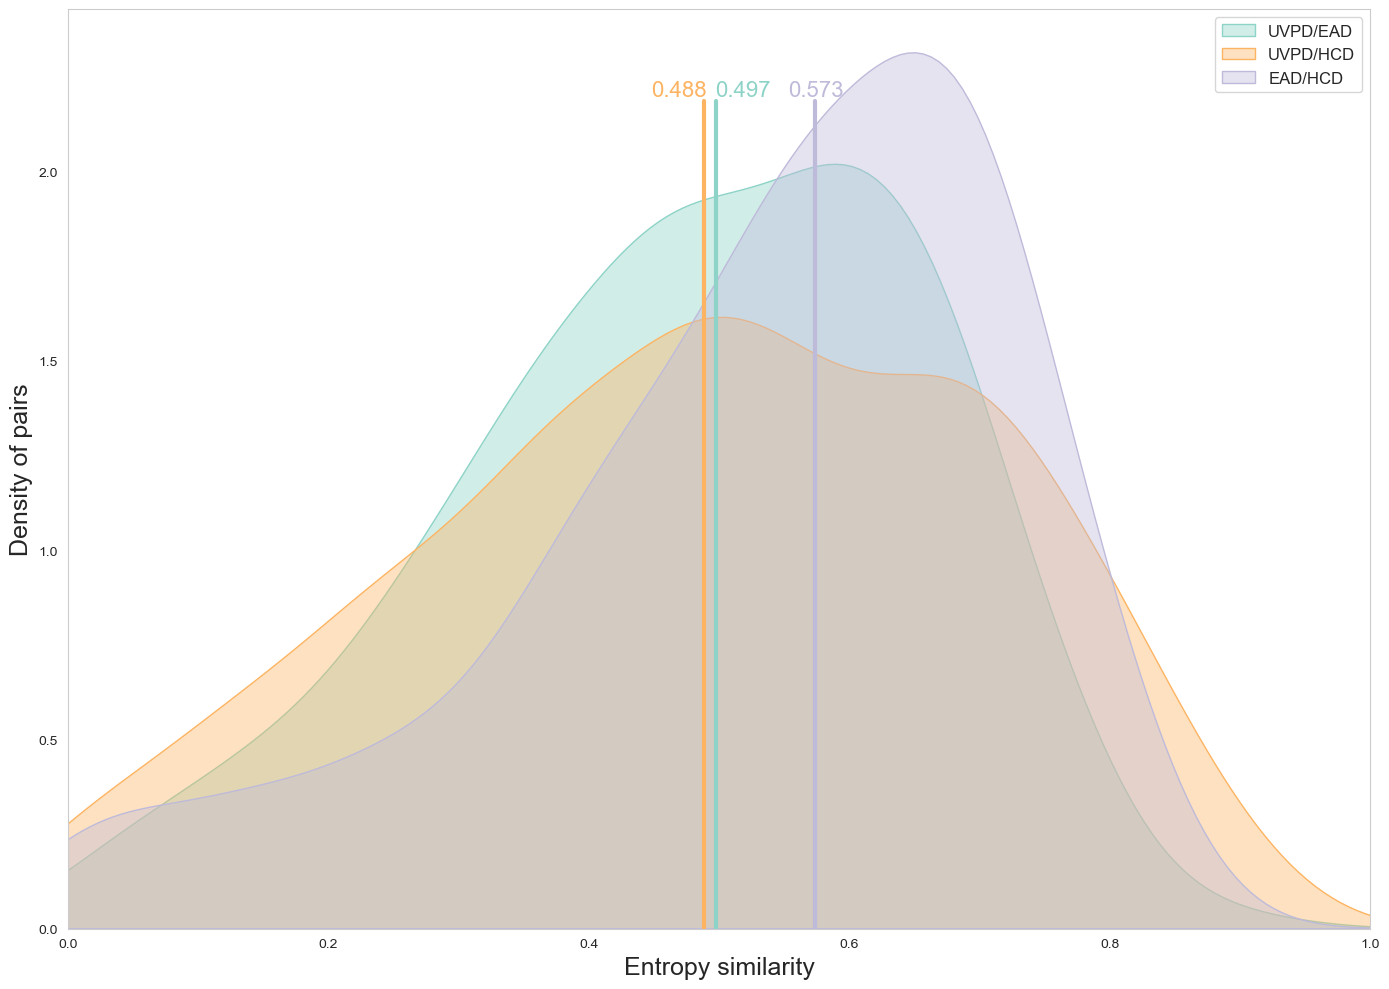

In [278]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(
    figsize = (14, 10)
                      )
# sns.histplot(data=uvpd_ead, x='entropy_similarity',color = sns.color_palette("Set1")[0],common_bins=True,
#              stat = 'probability',alpha = 0.4, cumulative=False, kde = True, binwidth = 0.05)
# sns.histplot(data=hcd_uvpd, x='entropy_similarity',color = sns.color_palette("Set1")[1], common_bins=True,
#              stat = 'probability',alpha = 0.4, cumulative=False,kde = True, binwidth = 0.05)
# sns.histplot(data=hcd_ead, x='entropy_similarity',color = sns.color_palette("Set1")[2], common_bins=True,
#              stat = 'probability',alpha = 0.4, cumulative=False, kde = True,binwidth = 0.05)
sns.kdeplot(data=uvpd_ead, x='entropy_similarity',color = sns.color_palette("Set3")[0],
             alpha = 0.4, fill=True)
sns.kdeplot(data=hcd_uvpd, x='entropy_similarity',color = sns.color_palette("Set3")[5],
             alpha = 0.4, fill=True)
sns.kdeplot(data=hcd_ead, x='entropy_similarity',color = sns.color_palette("Set3")[2],
             alpha = 0.4, fill=True)
# sns.histplot(data=uvpd_ead, x='entropy_similarity',color = sns.color_palette("Set2")[1], stat='probability', alpha = 0.4, cumulative=True)

# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Entropy similarity", fontsize = 18)
ax.set_ylabel("Density of pairs", fontsize = 18)
ax.grid(False)

plt.axvline(0.497397, 0, 0.9,color = sns.color_palette("Set3")[0],linewidth=3)
plt.axvline(0.488194, 0, 0.9,color = sns.color_palette("Set3")[5],linewidth=3 )
plt.axvline(0.573343, 0,0.9, color = sns.color_palette("Set3")[2] ,linewidth=3)
plt.text(0.497397, 2.2, "0.497", color = sns.color_palette("Set3")[0],fontsize=16)
plt.text(0.448194, 2.2, "0.488", color = sns.color_palette("Set3")[5],fontsize=16)
plt.text(0.553, 2.2, "0.573", color = sns.color_palette("Set3")[2],fontsize=16)
ax.set_xlim(0, 1)
plt.legend(labels=['UVPD/EAD','UVPD/HCD','EAD/HCD'], loc = 'upper right',fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figure_source,'entropy_similarities_libs.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

In [43]:
common_compounds_3 = find_common_items([uvpd_lib['key'], hcd_lib['key'], ead_lib['key']])

# Sample compound 1

In [44]:
n =3
test_compound_uvpd = string_search(uvpd_lib,'key', common_compounds_3[n])
test_compound_ead = string_search(ead_lib,'key', common_compounds_3[n])
test_compound_hcd = string_search(hcd_lib,'key', common_compounds_3[n])

In [319]:
from rdkit import Chem

In [56]:
from toolsets.spectra_plotter import ms2_plot, head_to_tail_plot
from rdkit import Chem
from rdkit.Chem import Draw

In [58]:
mol = Chem.MolFromSmiles(test_compound_ead.iloc[0]['reference_smiles'])
Draw.MolToFile(mol,os.path.join(figure_source, test_compound_ead.iloc[0]['reference_name']+test_compound_ead.iloc[0]['reference_adduct']+'mol_fig.png'))

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

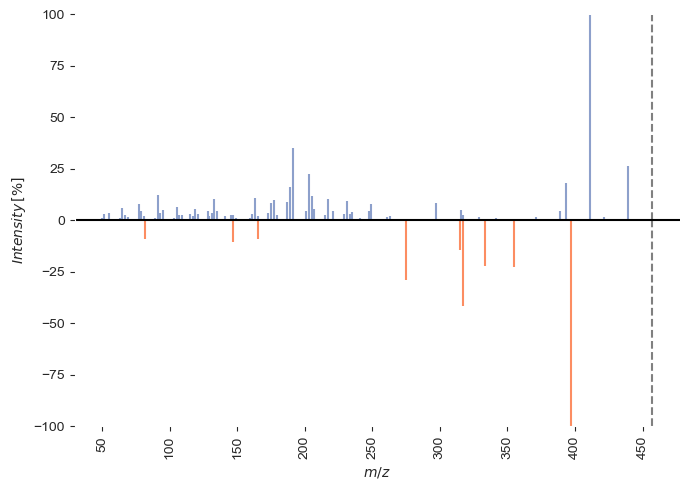

In [60]:
head_to_tail_plot(test_compound_ead.iloc[0]['peaks_denoised_normalized'],test_compound_hcd.iloc[0]['peaks_denoised_normalized'], pmz1 = test_compound_ead.iloc[0]['precursor_mz'],
                  pmz2 = test_compound_ead.iloc[0]['precursor_mz'],color1=sns.color_palette("Set2")[2],color2 =sns.color_palette("Set2")[1],
                                                                                                                              savepath=os.path.join(figure_source, test_compound_ead.iloc[0]['reference_name']+test_compound_ead.iloc[0]['reference_adduct']+'_ead_hcd.tiff')
                  )

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

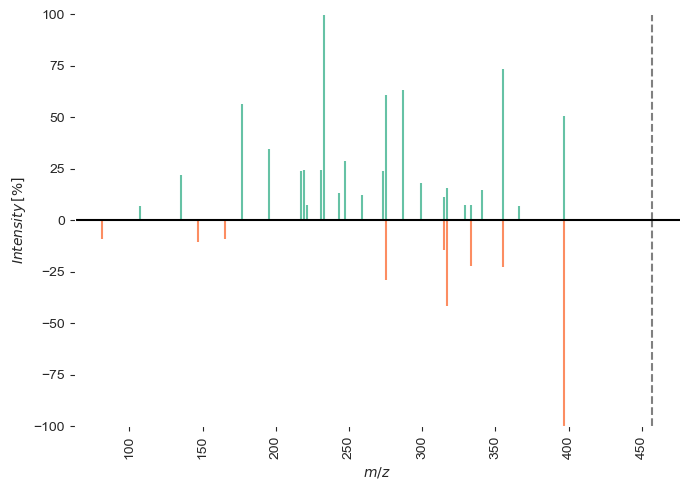

In [62]:
head_to_tail_plot(test_compound_uvpd.iloc[0]['peaks_denoised_normalized'],test_compound_hcd.iloc[0]['peaks_denoised_normalized'], pmz1 = test_compound_ead.iloc[0]['precursor_mz'],
                  pmz2 = test_compound_ead.iloc[0]['precursor_mz'],color1=sns.color_palette("Set2")[0],color2 =sns.color_palette("Set2")[1],
                                                                                                                              savepath=os.path.join(figure_source, test_compound_ead.iloc[0]['reference_name']+test_compound_ead.iloc[0]['reference_adduct']+'_uvpd_hcd.tiff')
                  )

# Sample Compound 2

In [63]:
n =2
test_compound_uvpd = string_search(uvpd_lib,'key', common_compounds_3[n])
test_compound_ead = string_search(ead_lib,'key', common_compounds_3[n])
test_compound_hcd = string_search(hcd_lib,'key', common_compounds_3[n])

In [64]:
mol = Chem.MolFromSmiles(test_compound_ead.iloc[0]['reference_smiles'])
Draw.MolToFile(mol,os.path.join(figure_source, test_compound_ead.iloc[0]['reference_name']+test_compound_ead.iloc[0]['reference_adduct']+'mol_fig.png'))

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

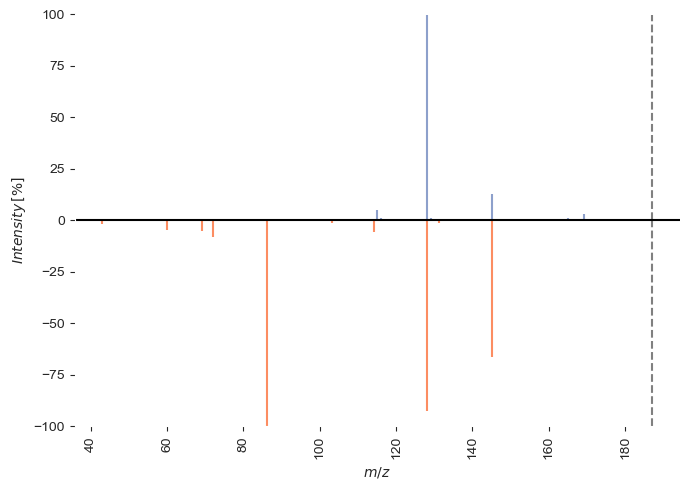

In [65]:
head_to_tail_plot(test_compound_ead.iloc[0]['peaks_denoised_normalized'],test_compound_hcd.iloc[0]['peaks_denoised_normalized'], pmz1 = test_compound_ead.iloc[0]['precursor_mz'],
                  pmz2 = test_compound_ead.iloc[0]['precursor_mz'],color1=sns.color_palette("Set2")[2],color2 =sns.color_palette("Set2")[1],
                                                                                                                              savepath=os.path.join(figure_source, test_compound_ead.iloc[0]['reference_name']+test_compound_ead.iloc[0]['reference_adduct']+'_ead_hcd.tiff')
                  )

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

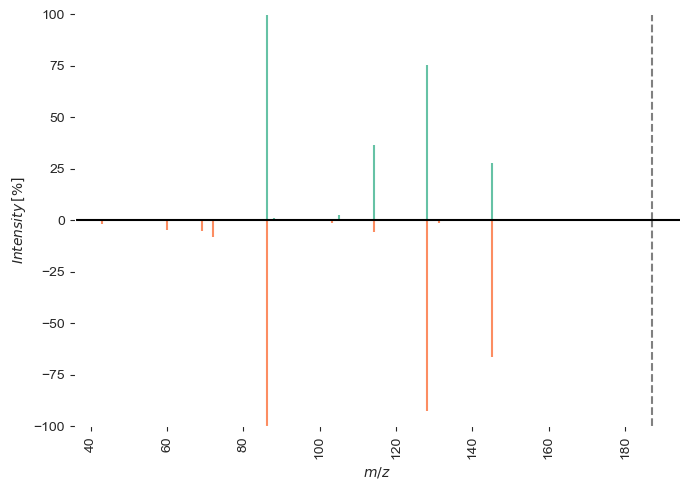

In [66]:
head_to_tail_plot(test_compound_uvpd.iloc[0]['peaks_denoised_normalized'],test_compound_hcd.iloc[0]['peaks_denoised_normalized'], pmz1 = test_compound_ead.iloc[0]['precursor_mz'],
                  pmz2 = test_compound_ead.iloc[0]['precursor_mz'],color1=sns.color_palette("Set2")[0],color2 =sns.color_palette("Set2")[1],
                                                                                                                              savepath=os.path.join(figure_source, test_compound_ead.iloc[0]['reference_name']+test_compound_ead.iloc[0]['reference_adduct']+'_uvpd_hcd.tiff')
                  )

# Sample compound 3

In [67]:
n =13
test_compound_uvpd = string_search(uvpd_lib,'key', common_compounds_3[n])
test_compound_ead = string_search(ead_lib,'key', common_compounds_3[n])
test_compound_hcd = string_search(hcd_lib,'key', common_compounds_3[n])

In [68]:
mol = Chem.MolFromSmiles(test_compound_ead.iloc[0]['reference_smiles'])
Draw.MolToFile(mol,os.path.join(figure_source, test_compound_ead.iloc[0]['reference_name']+test_compound_ead.iloc[0]['reference_adduct']+'mol_fig.png'))

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

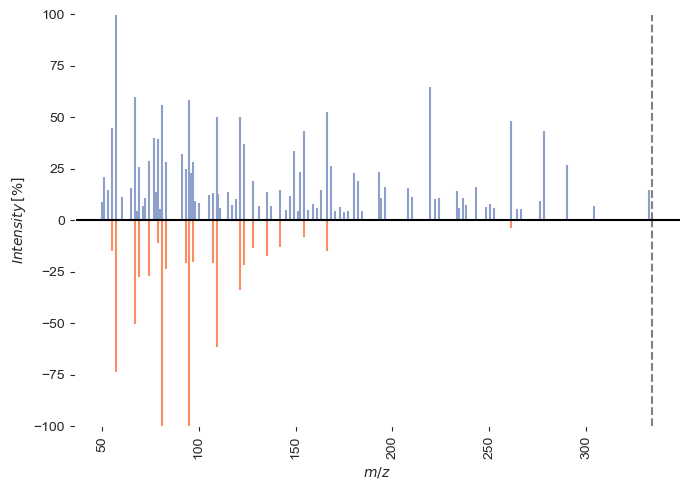

In [69]:
head_to_tail_plot(test_compound_ead.iloc[0]['peaks_denoised_normalized'],test_compound_hcd.iloc[0]['peaks_denoised_normalized'], pmz1 = test_compound_ead.iloc[0]['precursor_mz'],
                  pmz2 = test_compound_ead.iloc[0]['precursor_mz'],color1=sns.color_palette("Set2")[2],color2 =sns.color_palette("Set2")[1],
                                                                                                                              savepath=os.path.join(figure_source, test_compound_ead.iloc[0]['reference_name']+test_compound_ead.iloc[0]['reference_adduct']+'_ead_hcd.tiff')
                  )

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

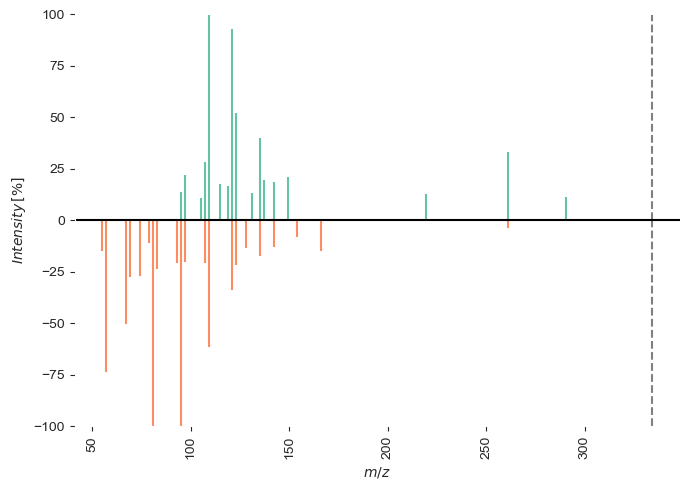

In [70]:
head_to_tail_plot(test_compound_uvpd.iloc[0]['peaks_denoised_normalized'],test_compound_hcd.iloc[0]['peaks_denoised_normalized'], pmz1 = test_compound_ead.iloc[0]['precursor_mz'],
                  pmz2 = test_compound_ead.iloc[0]['precursor_mz'],color1=sns.color_palette("Set2")[0],color2 =sns.color_palette("Set2")[1],
                                                                                                                              savepath=os.path.join(figure_source, test_compound_ead.iloc[0]['reference_name']+test_compound_ead.iloc[0]['reference_adduct']+'_uvpd_hcd.tiff')
                  )

# UVPD and HCD

# UVPD and HCD

In [72]:
entropy_similiary = []

for index, row in uvpd_lib.iterrows():
    data_temp = string_search(hcd_lib,'key',row['key'])
    if len(data_temp)!=0:
        entropy_similiary.append(entropy_similarity_default(row['peaks_denoised_normalized'], data_temp.iloc[0]['peaks_denoised_normalized']))
    else:
        entropy_similiary.append(np.NAN)
uvpd_lib['entropy_similarity_uvpd']=entropy_similiary
uvpd_for_plotting = uvpd_lib.dropna(subset=['entropy_similarity_uvpd'])
uvpd_for_plotting = string_search(uvpd_for_plotting, 'superclass', 'smiles_not_found', reverse=True)
uvpd_for_plotting = string_search(uvpd_for_plotting, 'superclass', 'classyfire_error_smiles', reverse=True)
uvpd_for_plotting['entropy_similarity_uvpd'].describe()

count    821.000000
mean       0.487965
std        0.219757
min        0.000000
25%        0.335698
50%        0.498185
75%        0.666490
max        0.926664
Name: entropy_similarity_uvpd, dtype: float64

In [79]:
uvpd_for_plotting['entropy_similarity_uvpd'].describe()['mean']

0.4879649172858039

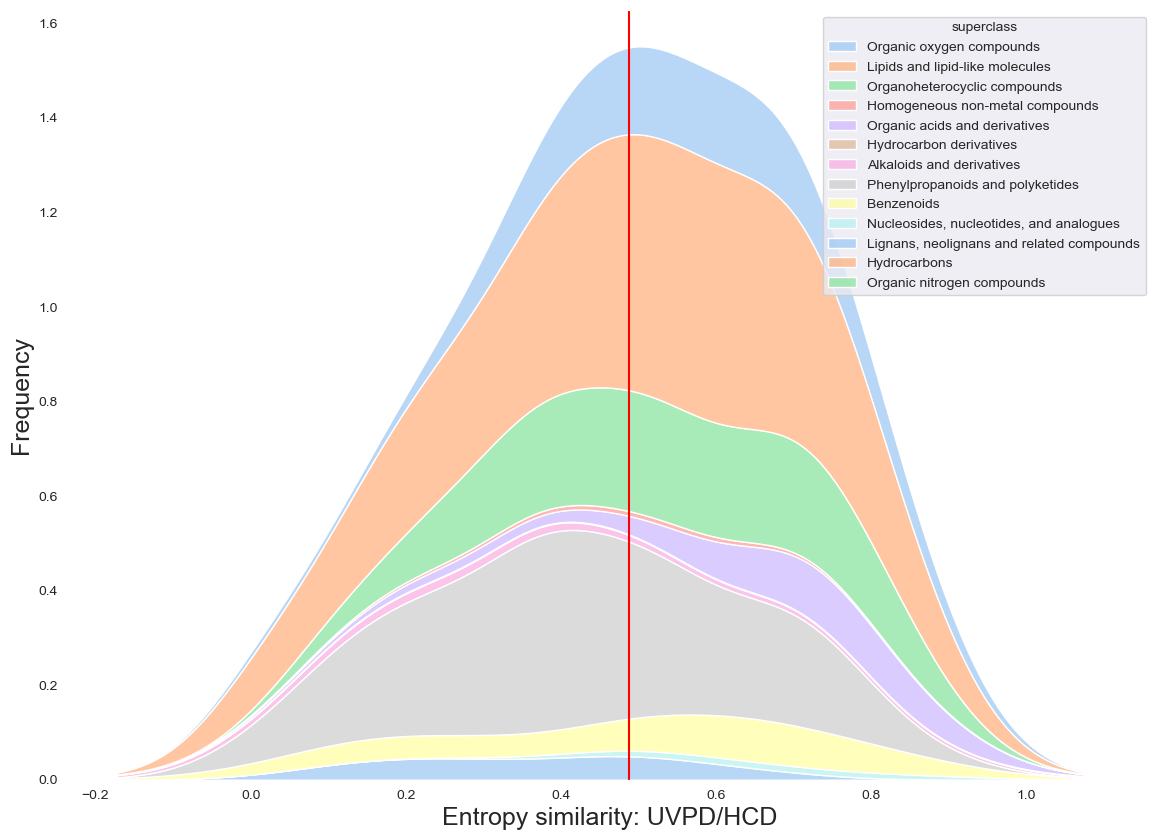

In [80]:
fig, ax = plt.subplots(
    figsize = (14, 10)
                      )
sns.kdeplot(data=uvpd_for_plotting, x='entropy_similarity_uvpd',hue="superclass", multiple="stack",palette="pastel")
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Entropy similarity: UVPD/HCD", fontsize = 18)
ax.set_ylabel("Frequency", fontsize = 18)
ax.grid(False)

plt.axvline(uvpd_for_plotting['entropy_similarity_uvpd'].describe()['mean'], 0, color = 'red' )
ax.set_facecolor('none')
# plt.axvline(0.478518, 0, color = sns.color_palette("tab10")[1] )
# plt.legend(labels=['ESI Neg','ESI Pos'], loc = 'upper right',fontsize=12)
plt.savefig(os.path.join(figure_source,'entropy_similarity_uvpd_hcd_by_class.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

In [75]:
entropy_similiary = []

for index, row in hcd_lib.iterrows():
    data_temp = string_search(ead_lib,'key',row['key'])
    if len(data_temp)!=0:
        entropy_similiary.append(entropy_similarity_default(row['peaks_denoised_normalized'], data_temp.iloc[0]['peaks_denoised_normalized']))
    else:
        entropy_similiary.append(np.NAN)
hcd_lib['entropy_similarity_ead']=entropy_similiary
hcd_lib_for_plotting = hcd_lib.dropna(subset=['entropy_similarity_ead'])
hcd_lib_for_plotting = string_search(hcd_lib_for_plotting, 'superclass', 'smiles_not_found', reverse=True)
hcd_lib_for_plotting = string_search(hcd_lib_for_plotting, 'superclass', 'classyfire_error_smiles', reverse=True)
hcd_lib_for_plotting['entropy_similarity_ead'].describe()

count    456.000000
mean       0.532549
std        0.192046
min        0.000000
25%        0.428616
50%        0.569496
75%        0.677699
max        0.853175
Name: entropy_similarity_ead, dtype: float64

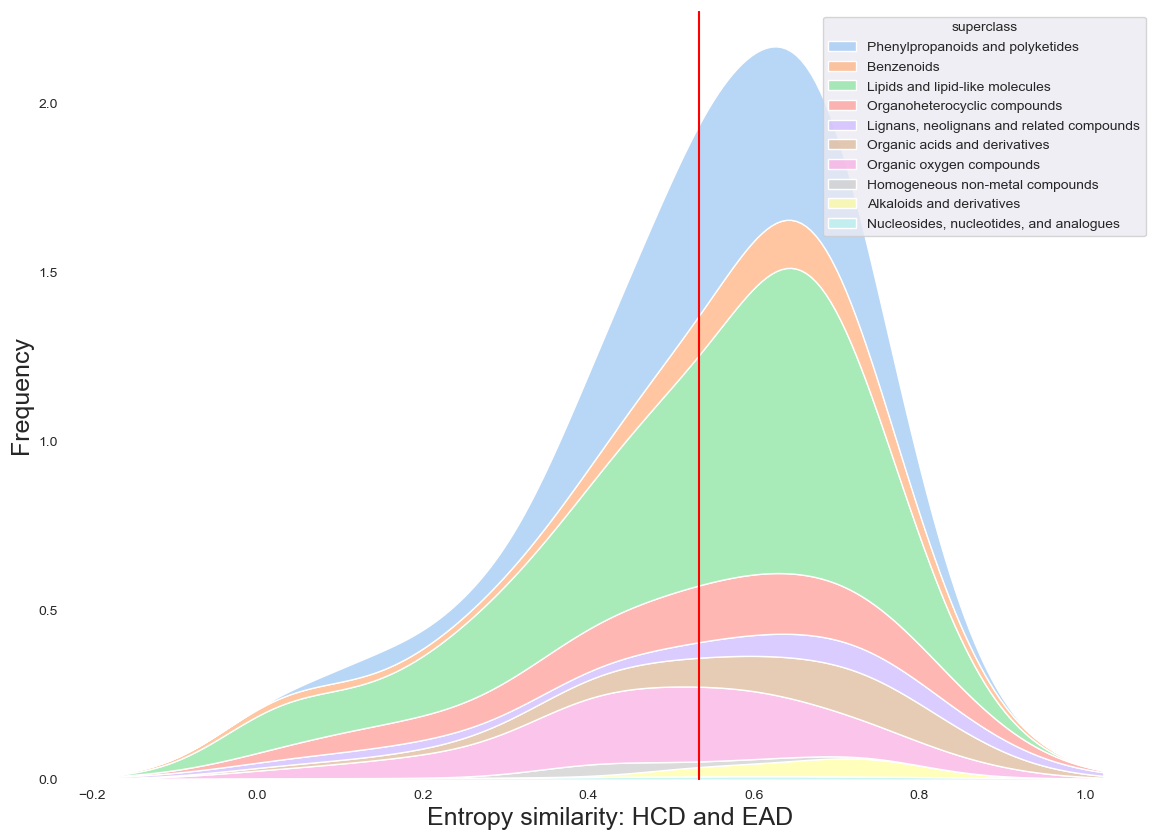

In [77]:
fig, ax = plt.subplots(
    figsize = (14, 10)
                      )
sns.kdeplot(data=hcd_lib_for_plotting, x='entropy_similarity_ead',hue="superclass", multiple="stack",palette="pastel")
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Entropy similarity: HCD and EAD", fontsize = 18)
ax.set_ylabel("Frequency", fontsize = 18)
ax.grid(False)

plt.axvline(0.533597, 0, color = 'red' )
# plt.axvline(0.478518, 0, color = sns.color_palette("tab10")[1] )
# plt.legend(labels=['ESI Neg','ESI Pos'], loc = 'upper right',fontsize=12)
ax.set_facecolor('none')
plt.savefig(os.path.join(figure_source,'entropy_similarity_ead_hcd_by_class.tiff'), dpi = 300,facecolor = 'none', edgecolor = 'none')

# what to do: spectra entropy, normalized_entropy, venn plot

In [10]:
len(set0)

795

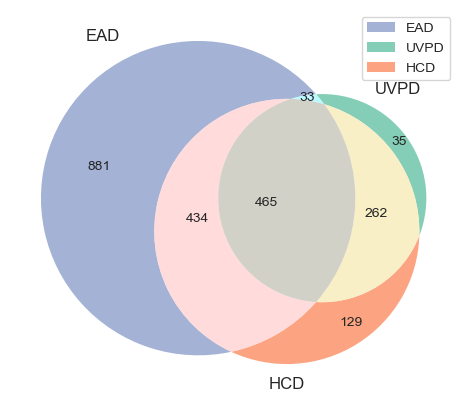

In [31]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted, venn3_circles, venn3, venn2_unweighted, venn2
set0 = set(uvpd_lib['reference_inchikey'])
set1 = set(hcd_lib['reference_inchikey'])
set2 = set(ead_lib['reference_inchikey'])



# set2 = set(string_search(data_good_quality,'reference_adduct','[M+Na]+')['reference_InChIKey'])
# set3 = set(string_search(data_good_quality,'reference_adduct','[M+NH4]+')['reference_InChIKey'])
fig, ax = plt.subplots(
    figsize = (7, 5)
                      )
# venn2([set1,set2],('POS','NEG'))
# venn3([set1, set2, set3], ('EAD', 'UVPD', 'HCD'))
v=venn3([set2,set0, set1 ], ('EAD','UVPD', 'HCD'), set_colors=(sns.color_palette('Set2')[2],sns.color_palette('Set2')[0],sns.color_palette('Set2')[1]), alpha=0.8)
# h, l = [],[]
# for i in [set2, set0, set1]:
#     # remove label by setting them to empty string:
#     v.get_label_by_id(i).set_text("")
#     # append patch to handles list
#     h.append(v.get_patch_by_id(i))
#     # append count to labels list
#     l.append(sets[i])
ax.legend(handles=[v.get_patch_by_id('100'),v.get_patch_by_id('010'),v.get_patch_by_id('001')], labels=('EAD','UVPD','HCD'))
# plt.show()
plt.savefig(os.path.join(figure_source,'venn_diagram_3_libs_weighted.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

In [23]:
v.get_patch_by_id('A')

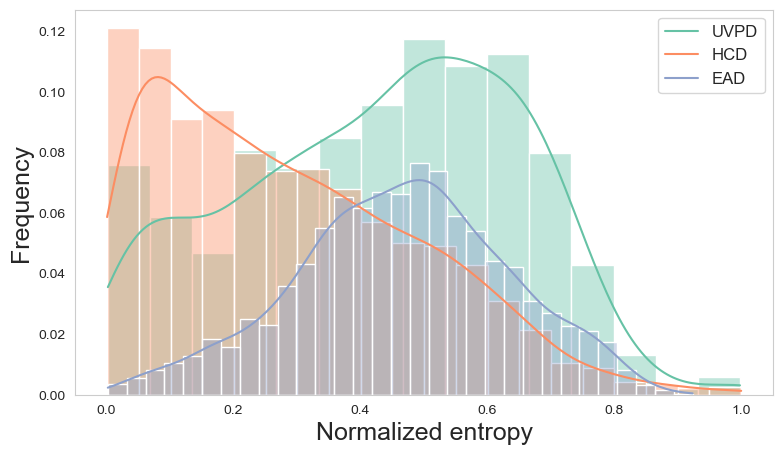

In [284]:
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )
# ax= sns.histplot(data=data_UVPD, x="normalized_entropy", multiple="stack", kde = True, palette="red")
# ax = sns.histplot(data=data_HCD, x="normalized_entropy", multiple="stack", kde = True,color="green")
ax=sns.histplot(data=uvpd_lib, x='normalized_entropy', multiple="stack",color = sns.color_palette("Set2")[0], alpha = 0.4,stat='probability',kde=True)
ax=sns.histplot(data=hcd_lib, x='normalized_entropy', multiple="stack",color = sns.color_palette("Set2")[1],alpha = 0.4,stat='probability',kde=True)
ax=sns.histplot(data=ead_lib, x='normalized_entropy', multiple="stack",color = sns.color_palette("Set2")[2],alpha = 0.4,stat='probability',kde=True)

ax.set_xlabel("Normalized entropy", fontsize = 18)
ax.set_ylabel("Frequency", fontsize = 18)
ax.grid(False)
plt.legend(labels=["UVPD","HCD",'EAD'], loc = 'upper right',fontsize=12)
plt.savefig(os.path.join(figure_source,'normalized_entropy_uvpd_hcd_ead.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

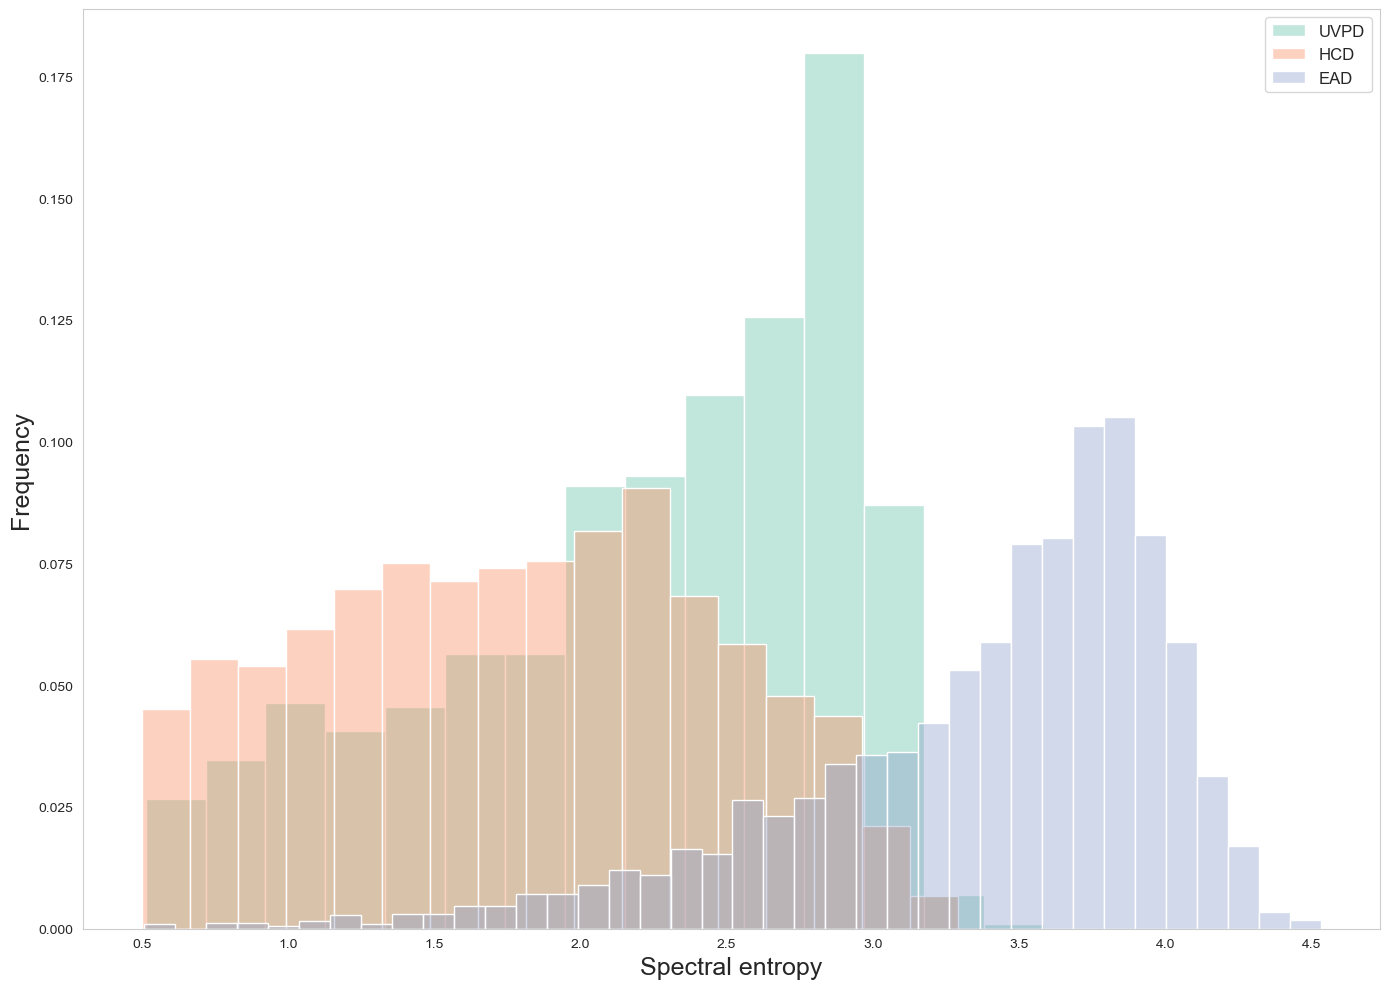

In [271]:
fig, ax = plt.subplots(
    figsize = (14, 10)
                      )
# ax= sns.histplot(data=data_UVPD, x="normalized_entropy", multiple="stack", kde = True, palette="red")
# ax = sns.histplot(data=data_HCD, x="normalized_entropy", multiple="stack", kde = True,color="green")
ax=sns.histplot(data=uvpd_lib, x='spectrum_entropy', multiple="stack",color = sns.color_palette("Set2")[0], alpha = 0.4,stat='probability')
ax=sns.histplot(data=hcd_lib, x='spectrum_entropy', multiple="stack",color = sns.color_palette("Set2")[1],alpha = 0.4,stat='probability')
ax=sns.histplot(data=ead_lib, x='spectrum_entropy', multiple="stack",color = sns.color_palette("Set2")[2],alpha = 0.4,stat='probability')
# ax.set_title("Peak number difference after denoising", fontsize = 16)
ax.set_xlabel("Spectral entropy", fontsize = 18)
ax.set_ylabel("Frequency", fontsize = 18)
ax.grid(False)
plt.legend(labels=["UVPD","HCD",'EAD'], loc = 'upper right',fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figure_source,'spectral_entropy_uvpd_hcd_ead.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

# pie charts

In [135]:
from toolsets.helpers import save_value_counts

In [156]:
vc = save_value_counts(uvpd_lib,'superclass')

In [195]:
vc

,unique_values,counts
0,Lipids and lipid-like molecules,1216
1,Phenylpropanoids and polyketides,436
2,Organic oxygen compounds,365
3,Organoheterocyclic compounds,353
4,Benzenoids,207
5,classyfire_error_smiles,206
6,Organic acids and derivatives,170
7,"Lignans, neolignans and related compounds",110
8,smiles_not_found,79
9,"Nucleosides, nucleotides, and analogues",47


In [196]:
def clean_vc(vc, end_index):
    from toolsets.search import string_search
    vc_valid = string_search(vc, 'unique_values','smiles_not_found', reverse=True)
    vc_valid = string_search(vc_valid, 'unique_values','classyfire_error_smiles', reverse=True)
    vc_selected = vc_valid[0:end_index]
    vc_leftover = vc[~vc['unique_values'].isin(vc_selected['unique_values'])]
    vc_selected= vc_selected.append(pd.DataFrame({'unique_values':['Others'],
                                              'counts':vc_leftover['counts'].sum()
                                              }), ignore_index=True)
    return(vc_selected)

In [186]:
def create_labels(vc_cleaned):
    labels = []
    for i in range(0,len(vc_cleaned)):
        labels.append(vc_cleaned.iloc[i]['unique_values']+' '+str(np.round(vc_cleaned.iloc[i]['counts']/(vc_cleaned['counts'].sum())*100,1))+ '%')
    return(labels)

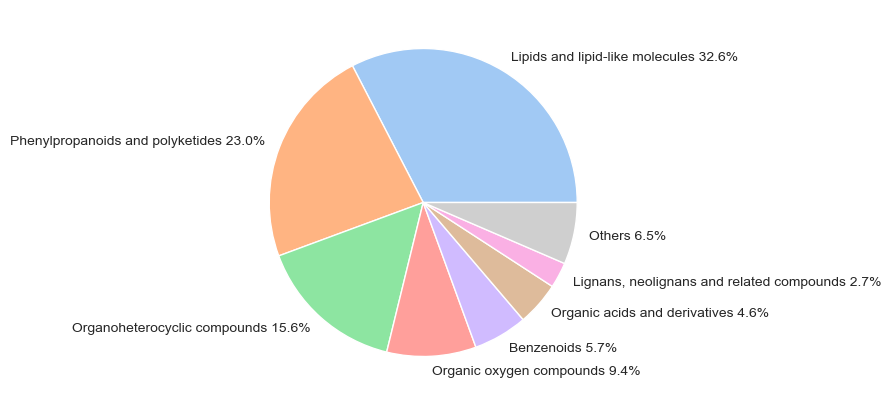

In [203]:
vc = save_value_counts(uvpd_lib,'superclass')
vc_cleaned = clean_vc(vc, 7)
labels = create_labels(vc_cleaned)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(
    figsize = (10, 5)
                      )
# labels=[f'{class_results.iloc[i]['Class']} {np.round(class_results.iloc[i]['counts']/sum(class_results.iloc[0:15]['counts'])*100,1)}%' for i in range(0,15)]
colors = sns.color_palette('pastel')[0:len(vc_cleaned)]
plt.pie(vc_cleaned['counts'], labels = labels,colors = colors
        # ,autopct='%.0f%%'
        )
# plt.show()
plt.savefig(os.path.join(figure_source, 'uvpd_pie_chart.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

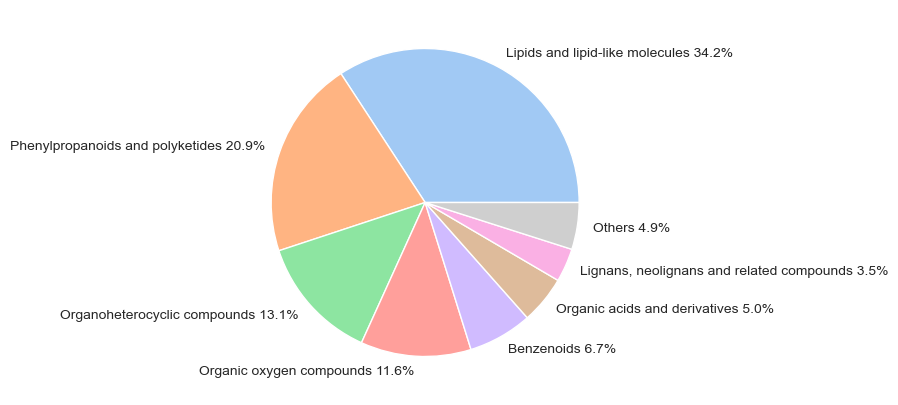

In [202]:
vc = save_value_counts(hcd_lib,'superclass')
vc_cleaned = clean_vc(vc, 7)
labels = create_labels(vc_cleaned)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(
    figsize = (10, 5)
                      )
# labels=[f'{class_results.iloc[i]['Class']} {np.round(class_results.iloc[i]['counts']/sum(class_results.iloc[0:15]['counts'])*100,1)}%' for i in range(0,15)]
colors = sns.color_palette('pastel')[0:len(vc_cleaned)]
plt.pie(vc_cleaned['counts'], labels = labels,colors = colors
        # ,autopct='%.0f%%'
        )
# plt.show()
plt.savefig(os.path.join(figure_source, 'hcd_pie_chart.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

In [192]:
from toolsets.API_gets import get_classyfire_data
ead_lib_cla= get_classyfire_data(ead_lib)

100%|██████████| 3244/3244 [08:12<00:00,  6.58it/s]


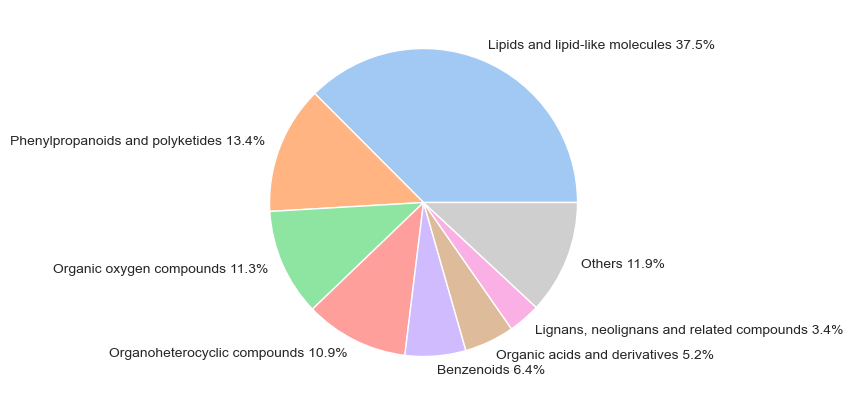

In [204]:
vc = save_value_counts(ead_lib_cla,'superclass')
vc_cleaned = clean_vc(vc, 7)
labels = create_labels(vc_cleaned)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(
    figsize = (10, 5)
                      )
# labels=[f'{class_results.iloc[i]['Class']} {np.round(class_results.iloc[i]['counts']/sum(class_results.iloc[0:15]['counts'])*100,1)}%' for i in range(0,15)]
colors = sns.color_palette('pastel')[0:len(vc_cleaned)]
plt.pie(vc_cleaned['counts'], labels = labels,colors = colors
        # ,autopct='%.0f%%'
        )
# plt.show()
plt.savefig(os.path.join(figure_source, 'ead_pie_chart.tiff'), dpi = 300,facecolor = 'white', edgecolor = 'white')

# searching biological samples

In [209]:
from toolsets.file_io import read_msp_files
from toolsets.spectra_operations import clean_spectrum

In [207]:
bio_pfp = pd.read_csv(os.path.join(ead_source_dir, 'pfp_bio_cleaned.csv'))
bio_hilic = pd.read_csv(os.path.join(ead_source_dir, 'hilic_bio_cleaned.csv'))

In [282]:
bio_pfp['RETENTIONTIME'].describe()

count    2431.000000
mean        4.055382
std         2.446630
min         0.109257
25%         1.376567
50%         5.397128
75%         6.012522
max         8.839057
Name: RETENTIONTIME, dtype: float64

In [213]:
peaks_cleaned = []
for index, row in tqdm(bio_hilic.iterrows(), total = len(bio_hilic)):
    peaks_cleaned.append(clean_spectrum(row['peaks'], row['PRECURSORMZ']))
bio_hilic['peaks_cleaned']=peaks_cleaned

100%|██████████| 3333/3333 [03:34<00:00, 15.51it/s]


In [214]:
peaks_cleaned = []
for index, row in tqdm(bio_pfp.iterrows(), total = len(bio_pfp)):
    peaks_cleaned.append(clean_spectrum(row['peaks'], row['PRECURSORMZ']))
bio_pfp['peaks_cleaned']=peaks_cleaned

100%|██████████| 2431/2431 [02:10<00:00, 18.65it/s]


In [279]:
from toolsets.msms_search import entropy_search_data
pfp_search_result = entropy_search_data(bio_pfp, ead_lib)

i am msms_search!!!!!


100%|██████████| 2431/2431 [00:02<00:00, 1038.68it/s]


In [281]:
pfp_search_result

,scan_number,precursor_mz,charge,ms1_intensity_ratio,ms1_precursor_intensity,retention_time,peaks,ms1_index,query_idx,reference_name,...,peaks_denoised_normalized,normalized_entropy,entropy_similarity_uvpd,kingdom,superclass,class,matched_entropy,sample_id,sample_peaks,sample_rt
0,114,211.095847,1,0.640620,1943.0,0.365567,50.01532\t0.00948797\n51.022797\t0.02699092\n5...,85,28,Sinapyl Alcohol,...,50.015589\t0.00958456\n51.023065\t0.0272657\n5...,0.576058,NaN,Organic compounds,Benzenoids,Phenols,0.778459,642,50.01551\t0.00605701\n51.02301\t0.02574103\n52...,5.808401
1,409,211.093863,1,0.623215,2706.0,1.333400,50.015339\t0.01215167\n51.022709\t0.03571689\n...,221,187,Nonic Acid,...,50.015617\t0.0124581\n51.022987\t0.03661667\n5...,0.433496,NaN,Organic compounds,Lipids and lipid-like molecules,Fatty Acyls,0.850683,642,50.01551\t0.00605701\n51.02301\t0.02574103\n52...,5.808401
2,287,211.094040,1,0.985214,31651.0,0.940667,50.015778\t0.0178024\n51.022633\t0.03425712\n5...,216,70,Azelaic acid,...,50.015264\t0.01785138\n51.022179\t0.03475662\n...,0.464645,NaN,Organic compounds,Lipids and lipid-like molecules,Fatty Acyls,0.846905,642,50.01551\t0.00605701\n51.02301\t0.02574103\n52...,5.808401
3,709,211.105092,1,0.805481,2704.0,2.136967,50.01511\t0.00930218\n51.023422\t0.04299902\n5...,688,20,N-Alpha-Acetyllysine,...,50.014974\t0.00954965\n51.023286\t0.04414378\n...,0.584645,NaN,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,0.789532,645,50.01482\t0.00775804\n51.02197\t0.02485912\n52...,5.875939
4,515,239.163492,1,0.652928,2297.0,1.406300,50.014916\t0.00597711\n51.023853\t0.01799056\n...,249,265,"3-hydroxy-5,5,8a-trimethyl-3,4,4a,6,7,8-hexahy...",...,50.014975\t0.0060188\n51.023911\t0.01811682\n5...,0.453056,NaN,Organic compounds,Organic acids and derivatives,Hydroxy acids and derivatives,0.798369,910,50.01534\t0.00781898\n51.02285\t0.01438696\n52...,0.203422
5,633,244.079013,1,1.000000,96935.0,1.957217,50.01432\t0.00617003\n51.023159\t0.01662908\n5...,591,41,N-Acetyl-D-Glucosamine,...,50.014936\t0.00726003\n51.023495\t0.01724281\n...,0.274309,NaN,Organic compounds,Organic oxygen compounds,Organooxygen compounds,0.754678,967,51.02011\t0.00945395\n52.02915\t0.00742796\n53...,0.222797
6,646,244.079357,1,0.988630,13825.0,1.973650,50.015877\t0.00663899\n51.023052\t0.03304197\n...,623,22,N-Acetylgalactosamine,...,50.016165\t0.00772118\n51.023289\t0.03462287\n...,0.361033,NaN,Organic compounds,Organic oxygen compounds,Organooxygen compounds,0.803737,967,51.02011\t0.00945395\n52.02915\t0.00742796\n53...,0.222797
7,228,245.185503,1,0.598795,2485.0,0.627933,50.015179\t0.00538578\n51.022758\t0.01653102\n...,121,106,Cedrol,...,50.015626\t0.00499072\n51.023177\t0.01715202\n...,0.350904,NaN,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,0.827288,983,50.01402\t0.003917\n51.02221\t0.01639498\n52.0...,1.381693
8,228,245.185503,1,0.598795,2485.0,0.627933,50.015179\t0.00538578\n51.022758\t0.01653102\n...,121,106,Cedrol,...,50.015626\t0.00499072\n51.023177\t0.01715202\n...,0.350904,NaN,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,0.889757,984,50.0146\t0.00460597\n51.0221\t0.01587689\n52.0...,1.601850
9,228,245.185503,1,0.598795,2485.0,0.627933,50.015179\t0.00538578\n51.022758\t0.01653102\n...,121,106,Cedrol,...,50.015626\t0.00499072\n51.023177\t0.01715202\n...,0.350904,NaN,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,0.847004,985,50.01552\t0.00639901\n51.02303\t0.01610802\n52...,1.829325


In [280]:
hilic_search_result = entropy_search_data(bio_hilic, ead_lib)

100%|██████████| 3333/3333 [00:03<00:00, 1100.91it/s]


In [286]:
from toolsets.spectra_plotter import head_to_tail_plot

In [288]:
hilic_search_result.iloc[1]

scan_number                                                                756
precursor_mz                                                          203.1503
charge                                                                       1
ms1_intensity_ratio                                                   0.998369
ms1_precursor_intensity                                               232607.0
retention_time                                                        2.273317
peaks                        55.040714\t0.002426\n56.042984\t0.004948\n57.0...
ms1_index                                                                  736
query_idx                                                                   19
reference_name                                            N,N-Dimethylarginine
reference_inchikey                                 YDGMGEXADBMOMJ-LURJTMIESA-N
reference_mix                                                         MSMLS 13
reference_smiles                                    

In [294]:
pfp_search_result.iloc[10]

scan_number                                                                149
precursor_mz                                                          247.1443
charge                                                                       1
ms1_intensity_ratio                                                   0.999076
ms1_precursor_intensity                                               224820.0
retention_time                                                        0.491567
peaks                        58.065254\t0.00985799\n59.073761\t0.002748\n59...
ms1_index                                                                  101
query_idx                                                                   47
reference_name                                                        lenticin
reference_inchikey                                 AOHCBEAZXHZMOR-UHFFFAOYSA-N
reference_mix                                                PFPpos_P N 26_EAD
reference_smiles                      C[N+](C)(C)C(C

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

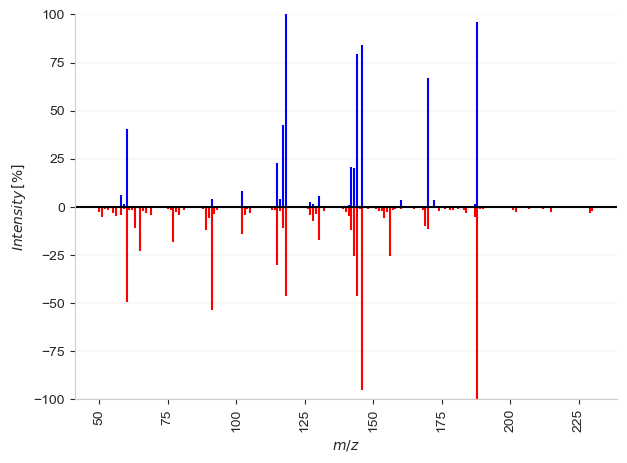

In [293]:
head_to_tail_plot(pfp_search_result.iloc[10]['peaks_denoised_normalized'], pfp_search_result.iloc[10]['sample_peaks'])

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

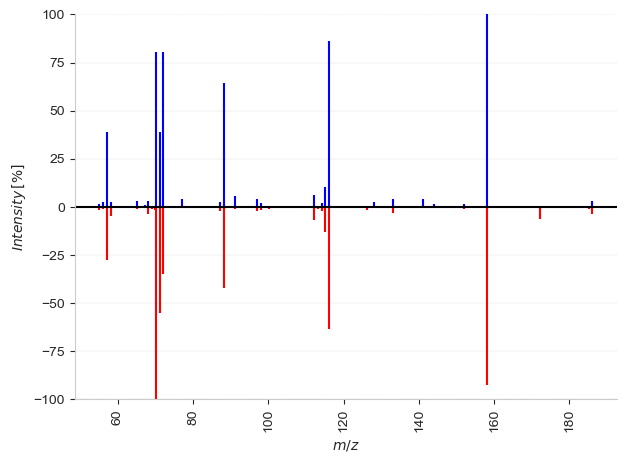

In [287]:
head_to_tail_plot(hilic_search_result.iloc[1]['peaks_denoised_normalized'], hilic_search_result.iloc[1]['sample_peaks'])

In [285]:
from

,scan_number,precursor_mz,charge,ms1_intensity_ratio,ms1_precursor_intensity,retention_time,peaks,ms1_index,query_idx,reference_name,...,peaks_denoised_normalized,normalized_entropy,entropy_similarity_uvpd,kingdom,superclass,class,matched_entropy,sample_id,sample_peaks,sample_rt
0,87,203.053602,1,0.995470,47242.0,0.252000,50.015556\t0.01453277\n51.023399\t0.0544288\n5...,80,6,Theophylline,...,50.014905\t0.01582833\n51.02275\t0.05928026\n5...,0.620901,NaN,Organic compounds,Organoheterocyclic compounds,Imidazopyrimidines,0.824823,2055,50.01646\t0.00875598\n51.02259\t0.02396295\n52...,7.938608
1,756,203.150300,1,0.998369,232607.0,2.273317,55.040714\t0.002426\n56.042984\t0.004948\n57.0...,736,19,"N,N-Dimethylarginine",...,55.04081\t0.00244426\n56.043079\t0.00498524\n5...,0.272792,NaN,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,0.946895,2082,55.03298\t0.00373101\n56.04263\t0.002256\n57.0...,8.982611
2,605,204.123161,1,0.999467,594840.0,1.818150,57.035572\t0.12979913\n58.06686\t0.12528213\n5...,564,40,Acetyl-DL-carnitine,...,57.035272\t0.13138734\n58.06656\t0.12681507\n5...,0.311654,NaN,smiles_not_found,smiles_not_found,smiles_not_found,0.935833,2114,57.03416\t0.097181\n58.06864\t0.089147\n59.074...,7.260529
3,607,204.123009,1,0.999611,844698.0,1.817350,57.035358\t0.15752416\n58.066803\t0.11134511\n...,595,11,O-Acetylcarnitine,...,57.035188\t0.15902183\n58.066634\t0.11240373\n...,0.506252,NaN,smiles_not_found,smiles_not_found,smiles_not_found,0.908059,2114,57.03416\t0.097181\n58.06864\t0.089147\n59.074...,7.260529
4,709,211.105092,1,0.805481,2704.0,2.136967,50.01511\t0.00930218\n51.023422\t0.04299902\n5...,688,20,N-Alpha-Acetyllysine,...,50.014974\t0.00954965\n51.023286\t0.04414378\n...,0.584645,NaN,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,0.858864,2303,50.01508\t0.00960789\n51.02329\t0.02083577\n52...,1.723033


In [271]:
search_result = pd.DataFrame()
for index, row in tqdm(bio_hilic.iterrows(), total = len(bio_hilic)):
    result_temp = entropy_search_fast(row['peaks_cleaned'], row['PRECURSORMZ'], ead_lib)
    if result_temp is not np.NAN:

        result_temp['sample_id']=row['Comment']
        result_temp['sample_peaks']=row['peaks_cleaned']
        search_result = search_result.append(result_temp)
        # break

100%|██████████| 3333/3333 [00:03<00:00, 1061.41it/s]


In [274]:
search_result

,scan_number,precursor_mz,charge,ms1_intensity_ratio,ms1_precursor_intensity,retention_time,peaks,ms1_index,query_idx,reference_name,...,ei,peaks_denoised_normalized,normalized_entropy,entropy_similarity_uvpd,kingdom,superclass,class,matched_entropy,sample_id,sample_peaks
0,87,203.053602,1,0.995470,47242.0,0.252000,50.015556\t0.01453277\n51.023399\t0.0544288\n5...,80,6,Theophylline,...,91.81613,50.014905\t0.01582833\n51.02275\t0.05928026\n5...,0.620901,NaN,Organic compounds,Organoheterocyclic compounds,Imidazopyrimidines,0.824823,2055,50.01646\t0.00875598\n51.02259\t0.02396295\n52...
0,756,203.150300,1,0.998369,232607.0,2.273317,55.040714\t0.002426\n56.042984\t0.004948\n57.0...,736,19,"N,N-Dimethylarginine",...,99.25290,55.04081\t0.00244426\n56.043079\t0.00498524\n5...,0.272792,NaN,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,0.946895,2082,55.03298\t0.00373101\n56.04263\t0.002256\n57.0...
0,605,204.123161,1,0.999467,594840.0,1.818150,57.035572\t0.12979913\n58.06686\t0.12528213\n5...,564,40,Acetyl-DL-carnitine,...,98.79120,57.035272\t0.13138734\n58.06656\t0.12681507\n5...,0.311654,NaN,smiles_not_found,smiles_not_found,smiles_not_found,0.935833,2114,57.03416\t0.097181\n58.06864\t0.089147\n59.074...
1,607,204.123009,1,0.999611,844698.0,1.817350,57.035358\t0.15752416\n58.066803\t0.11134511\n...,595,11,O-Acetylcarnitine,...,99.05820,57.035188\t0.15902183\n58.066634\t0.11240373\n...,0.506252,NaN,smiles_not_found,smiles_not_found,smiles_not_found,0.908059,2114,57.03416\t0.097181\n58.06864\t0.089147\n59.074...
0,709,211.105092,1,0.805481,2704.0,2.136967,50.01511\t0.00930218\n51.023422\t0.04299902\n5...,688,20,N-Alpha-Acetyllysine,...,97.40651,50.014974\t0.00954965\n51.023286\t0.04414378\n...,0.584645,NaN,Organic compounds,Organic acids and derivatives,Carboxylic acids and derivatives,0.858864,2303,50.01508\t0.00960789\n51.02329\t0.02083577\n52...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,798,527.158593,1,0.992200,12212.0,2.467383,50.015698\t0.00796098\n51.022568\t0.02001294\n...,748,49,Maltotriose,...,100.00000,50.015967\t0.00796098\n51.022836\t0.02001294\n...,0.600265,NaN,Organic compounds,Organic oxygen compounds,Organooxygen compounds,0.838488,10783,50.01505\t0.00675897\n51.02185\t0.01271094\n52...
1,87,583.254433,1,0.991133,37112.0,0.254000,50.015503\t0.00319489\n51.022984\t0.00588441\n...,79,6,Biliverdin,...,100.00000,50.014841\t0.00319499\n51.022324\t0.00588399\n...,0.512838,NaN,Organic compounds,Organoheterocyclic compounds,Tetrapyrroles and derivatives,0.809412,11853,50.0157\t0.00231305\n51.02321\t0.00854518\n52....
1,87,583.254433,1,0.991133,37112.0,0.254000,50.015503\t0.00319489\n51.022984\t0.00588441\n...,79,6,Biliverdin,...,100.00000,50.014841\t0.00319499\n51.022324\t0.00588399\n...,0.512838,NaN,Organic compounds,Organoheterocyclic compounds,Tetrapyrroles and derivatives,0.810637,11854,50.01639\t0.000692\n51.02321\t0.000583\n62.015...
0,858,689.211712,1,0.988725,3683.0,2.588550,50.01601\t0.01068605\n51.022984\t0.02656658\n5...,837,20,Stachyose,...,100.00000,50.01606\t0.01068593\n51.023033\t0.02656681\n5...,0.585052,NaN,Organic compounds,Organic oxygen compounds,Organooxygen compounds,0.759245,13329,50.01433\t0.00347507\n51.02253\t0.00686414\n52...


In [275]:
len(search_result['sample_id'].unique())

61

In [276]:
len(search_result_pfp['sample_id'].unique())

32

In [252]:
indices = []
my_list = [1,20,4,690]
for index, item in enumerate(my_list):
    if item > 10:
        indices.append(index)

In [254]:
indices

[1, 3]

In [255]:
my_list[1,3]

TypeError: list indices must be integers or slices, not tuple

In [241]:
entropy_similarity_default(aa.iloc[0]['peaks_denoised_normalized'], row['peaks_cleaned'])

0.849038829230666

In [231]:
result_temp[1]['retention_time']

1.3334

In [219]:
from toolsets.msms_search import entropy_search_fast

In [220]:
ead_lib

,scan_number,precursor_mz,charge,ms1_intensity_ratio,ms1_precursor_intensity,retention_time,peaks,ms1_index,query_idx,reference_name,...,peaks_recalibrated_wa,retention_time_wa,peaks_denoised,ei,peaks_denoised_normalized,normalized_entropy,entropy_similarity_uvpd,kingdom,superclass,class
0,523,749.299550,1,0.968634,42586.0,1.578950,127.055244\t0.00451007\n128.060577\t0.01033574...,329,193,"(2R,3S,4S,5R,6R)-6-[1,7-bis(4-hydroxyphenyl)he...",...,50.015493\t0.002077\n51.023041\t0.00914998\n52...,1.566822,50.015493\t0.002077\n51.023041\t0.00914998\n52...,100.00000,50.015493\t0.002077\n51.023041\t0.00914998\n52...,0.474286,NaN,Organic compounds,Phenylpropanoids and polyketides,Diarylheptanoids
1,518,744.344402,1,0.999243,295804.0,1.568617,50.014946\t0.003061\n51.023922\t0.01373499\n53...,328,189,"(2R,3S,4S,5R,6R)-6-[1,7-bis(4-hydroxyphenyl)he...",...,50.015203\t0.003061\n51.024178\t0.01373499\n53...,1.568617,50.015203\t0.003061\n51.024178\t0.01373499\n53...,99.02380,50.015203\t0.00309118\n51.024178\t0.01387039\n...,0.561727,0.556888,Organic compounds,Phenylpropanoids and polyketides,Diarylheptanoids
2,521,727.317616,1,0.712541,5892.0,1.575500,127.054512\t0.00603489\n128.061432\t0.01494435...,328,191,"(2R,3S,4S,5R,6R)-6-[1,7-bis(4-hydroxyphenyl)he...",...,127.054973\t0.00664201\n128.061881\t0.01696303...,1.568086,127.054973\t0.00664201\n128.061881\t0.01696303...,100.00000,127.054973\t0.00664201\n128.061881\t0.01696303...,0.449299,NaN,Organic compounds,Phenylpropanoids and polyketides,Diarylheptanoids
3,734,1205.496037,1,0.907086,7732.0,2.293450,127.054962\t0.01068208\n128.060287\t0.04754418...,453,280,"[(2R,3R,4R,6S)-6-[[(6S,7S)-6-[(2S,4R,5R,6R)-4-...",...,127.055025\t0.01068204\n128.06035\t0.04754419\...,2.293450,127.055025\t0.01068204\n128.06035\t0.04754419\...,99.48690,127.055025\t0.01073713\n128.06035\t0.0477894\n...,0.727409,NaN,Organic compounds,Organic oxygen compounds,Organooxygen compounds
4,697,348.180383,1,0.770097,9024.0,2.186000,115.054825\t0.00947399\n116.058647\t0.002788\n...,501,194,3-(4-hydroxy-3-methoxyphenyl)propyl 3-(4-hydro...,...,115.053922\t0.00947399\n116.057747\t0.002788\n...,2.186000,115.053922\t0.00947399\n116.057747\t0.002788\n...,99.67850,115.053922\t0.00950455\n116.057747\t0.00279699...,0.248720,NaN,Organic compounds,Benzenoids,Phenols
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239,607,943.526070,1,0.999077,88803.0,2.019833,115.054176\t0.00500109\n117.069016\t0.0033146\...,352,253,"[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl] ...",...,115.05448\t0.00500099\n117.069321\t0.003315\n1...,2.019833,115.05448\t0.00500099\n117.069321\t0.003315\n1...,100.00000,115.05448\t0.00500099\n117.069321\t0.003315\n1...,0.447164,NaN,Organic compounds,Lipids and lipid-like molecules,Prenol lipids
3240,121,318.221455,1,0.999843,8282372.0,0.246300,115.05208\t0.00662799\n132.09534\t0.04321996\n...,68,51,Butenafine,...,115.052516\t0.00627499\n119.088862\t0.000256\n...,0.247482,115.052516\t0.00627499\n119.088862\t0.000256\n...,93.28271,115.052516\t0.00672685\n119.088862\t0.00027443...,0.051425,NaN,Organic compounds,Benzenoids,Naphthalenes
3241,573,376.174011,1,0.961134,14986.0,1.637433,115.055313\t0.00925897\n117.068474\t0.00401999...,280,291,"(1R,2S,3S,5S,11R,12R)-5-(furan-3-yl)-12-hydrox...",...,115.055683\t0.00925897\n117.068842\t0.00401999...,1.637433,115.055683\t0.00925897\n117.068842\t0.00401999...,100.00000,115.055683\t0.00925897\n117.068842\t0.00401999...,0.610714,NaN,Organic compounds,Organoheterocyclic compounds,Naphthopyrans
3242,572,359.148402,1,0.999184,777535.0,1.635700,115.055695\t0.004953\n117.071503\t0.002446\n12...,280,290,"(1R,2S,3S,5S,11R,12R)-5-(furan-3-yl)-12-hydrox...",...,115.056065\t0.004953\n117.071871\t0.002446\n12...,1.635700,115.056065\t0.004953\n117.071871\t0.002446\n12...,100.00000,115.056065\t0.004953\n117.071871\t0.002446\n12...,0.700247,NaN,Organic compounds,Organoheterocyclic compounds,Naphthopyrans


In [223]:
test = entropy_search_fast(row['peaks_cleaned'], row['PRECURSORMZ'], ead_lib)

i am msms_search!!!!!


In [225]:
test is not np.NAN

False